In [0]:
%python
%pip install kagglehub
import pandas as pd
import io
import requests
import kagglehub

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
# Baixar
path = kagglehub.dataset_download("heesoo37/120-years-of-olympic-history-athletes-and-results")
print("Path to dataset files:", path)

Path to dataset files: /home/spark-ce4028b6-3b2d-4189-ac49-ec/.cache/kagglehub/datasets/heesoo37/120-years-of-olympic-history-athletes-and-results/versions/2


In [0]:
# Ler o arquivo CSV diretamente para um DataFrame do pandas
df_athletes = pd.read_csv(f"{path}/athlete_events.csv")
df_noc = pd.read_csv(f"{path}/noc_regions.csv")

# Converter para Spark DataFrame
spark_df_athletes = spark.createDataFrame(df_athletes)
spark_df_noc = spark.createDataFrame(df_noc)

# Criar views temporárias para trabalhar com SQL
spark_df_athletes.createOrReplaceTempView("raw_athlete_events")
spark_df_noc.createOrReplaceTempView("raw_noc_regions")

In [0]:
%sql
CREATE DATABASE IF NOT EXISTS olympics_dw;
USE olympics_dw;

In [0]:
%sql
CREATE TABLE dim_athletes (
    athlete_id INT PRIMARY KEY,
    name STRING,
    sex STRING,
    age INT,
    height FLOAT,
    weight FLOAT,
    team STRING,
    noc STRING
) USING DELTA;

INSERT INTO dim_athletes
SELECT DISTINCT
    id AS athlete_id,
    name,
    sex,
    age,
    height,
    weight,
    team,
    noc
FROM raw_athlete_events;

num_affected_rows num_inserted_rows 188778 188778

In [0]:
%sql
CREATE TABLE dim_events (
    event_id INT PRIMARY KEY,
    sport STRING,
    event_name STRING,
    season STRING
) USING DELTA;

INSERT INTO dim_events
SELECT 
    monotonically_increasing_id() AS event_id,
    sport,
    event AS event_name,
    season
FROM (
    SELECT DISTINCT sport, event, season 
    FROM raw_athlete_events
);

num_affected_rows num_inserted_rows 770 770

In [0]:
%sql
CREATE TABLE dim_time (
    time_id INT PRIMARY KEY,
    year INT,
    season STRING,
    games STRING
) USING DELTA;

INSERT INTO dim_time
SELECT 
    monotonically_increasing_id() AS time_id,
    year,
    season,
    games
FROM (
    SELECT DISTINCT year, season, games 
    FROM raw_athlete_events
);

num_affected_rows num_inserted_rows 51 51

In [0]:
%sql
CREATE TABLE dim_locations (
    location_id INT PRIMARY KEY,
    city STRING,
    country STRING,
    noc STRING,
    region STRING
) USING DELTA;

INSERT INTO dim_locations
SELECT 
    monotonically_increasing_id() AS location_id,
    rae.city,
    rnr.region AS country,
    rae.noc,
    rnr.notes AS region
FROM (
    SELECT DISTINCT city, noc 
    FROM raw_athlete_events
) rae
LEFT JOIN raw_noc_regions rnr ON rae.noc = rnr.noc;

num_affected_rows num_inserted_rows 3606 3606

In [0]:
%sql
CREATE TABLE IF NOT EXISTS olympics_dw.fact_results (
    result_id INT PRIMARY KEY,
    athlete_id INT,
    event_id INT,
    time_id INT,
    location_id INT,
    medal STRING,
    FOREIGN KEY (athlete_id) REFERENCES dim_athletes(athlete_id),
    FOREIGN KEY (event_id) REFERENCES dim_events(event_id),
    FOREIGN KEY (time_id) REFERENCES dim_time(time_id),
    FOREIGN KEY (location_id) REFERENCES dim_locations(location_id)
) USING DELTA;

In [0]:
%sql
-- Verificar se os dados foram inseridos corretamente
SELECT COUNT(*) FROM olympics_dw.fact_results;

-- Visualizar alguns registros
SELECT * FROM olympics_dw.fact_results LIMIT 10;

result_id athlete_id event_id time_id location_id medal 60129542144 118969 16 39 929 null 60129542145 118970 189 46 713 Bronze 60129542146 118970 189 17 468 Silver 60129542147 118971 166 8 432 Bronze 60129542148 118971 166 38 64 null 60129542149 118971 166 34 2263 null 60129542150 118972 340 15 302 null 60129542151 118973 365 46 1580 null 60129542152 118973 180 46 1580 null 60129542153 118973 526 17 918 null

In [0]:
%sql
-- 1. Primeiro drope a tabela existente
DROP TABLE IF EXISTS olympics_dw.fact_results;

-- 2. Recrie com BIGINT para a chave primária
CREATE TABLE olympics_dw.fact_results (
    result_id BIGINT PRIMARY KEY,  -- Alterado para BIGINT
    athlete_id INT,
    event_id INT,
    time_id INT,
    location_id INT,
    medal STRING,
    FOREIGN KEY (athlete_id) REFERENCES dim_athletes(athlete_id),
    FOREIGN KEY (event_id) REFERENCES dim_events(event_id),
    FOREIGN KEY (time_id) REFERENCES dim_time(time_id),
    FOREIGN KEY (location_id) REFERENCES dim_locations(location_id)
) USING DELTA;

-- 3. Agora a inserção funcionará sem erros
INSERT INTO olympics_dw.fact_results
SELECT
    monotonically_increasing_id() AS result_id,  -- Agora compatível com BIGINT
    a.athlete_id,
    e.event_id,
    t.time_id,
    l.location_id,
    rae.medal
FROM raw_athlete_events rae
JOIN dim_athletes a ON rae.id = a.athlete_id
JOIN dim_events e ON rae.sport = e.sport AND rae.event = e.event_name
JOIN dim_time t ON rae.year = t.year AND rae.games = t.games
JOIN dim_locations l ON rae.city = l.city AND rae.noc = l.noc;

num_affected_rows num_inserted_rows 510705 510705

In [0]:
%sql
-- Verifique se todos os IDs foram inseridos corretamente
SELECT 
    COUNT(*) AS total_rows,
    COUNT(DISTINCT result_id) AS distinct_ids,
    MIN(result_id) AS min_id,
    MAX(result_id) AS max_id
FROM olympics_dw.fact_results;

-- Se distinct_ids < total_rows, há IDs duplicados (isso não deve acontecer)

total_rows distinct_ids min_id max_id 510705 510705 0 60129606297

In [0]:
%sql
-- Verificação de contagem de registros
SELECT 'dim_athletes' AS table_name, COUNT(*) AS record_count FROM dim_athletes
UNION ALL SELECT 'dim_events', COUNT(*) FROM dim_events
UNION ALL SELECT 'dim_time', COUNT(*) FROM dim_time
UNION ALL SELECT 'dim_locations', COUNT(*) FROM dim_locations
UNION ALL SELECT 'fact_results', COUNT(*) FROM fact_results;

table_name record_count dim_athletes 188778 dim_events 770 dim_time 51 dim_locations 3606 fact_results 510705

In [0]:
%sql
-- Medalhas por país e esporte
SELECT 
    l.country,
    e.sport,
    COUNT(CASE WHEN fr.medal = 'Gold' THEN 1 END) AS gold_medals,
    COUNT(CASE WHEN fr.medal = 'Silver' THEN 1 END) AS silver_medals,
    COUNT(CASE WHEN fr.medal = 'Bronze' THEN 1 END) AS bronze_medals
FROM fact_results fr
JOIN dim_locations l ON fr.location_id = l.location_id
JOIN dim_events e ON fr.event_id = e.event_id
GROUP BY l.country, e.sport
ORDER BY gold_medals DESC
LIMIT 20;

country sport gold_medals silver_medals bronze_medals USA Swimming 1171 477 341 USA Athletics 1015 557 369 Canada Ice Hockey 620 226 94 Russia Ice Hockey 612 194 162 Germany Rowing 469 156 184 USA Basketball 459 24 56 Italy Fencing 412 354 217 Russia Gymnastics 333 259 164 Germany Equestrianism 310 108 136 France Fencing 309 228 228 Hungary Water Polo 306 74 102 Hungary Fencing 299 166 197 Russia Fencing 283 143 140 Russia Athletics 256 255 261 USA Rowing 255 159 125 Australia Swimming 255 330 239 Germany Canoeing 244 161 122 India Hockey 231 29 52 UK Rowing 228 224 89 Romania Rowing 217 154 120

In [0]:
# Análise
completeness_analysis = spark.sql("""
SELECT
    COUNT(*) AS total_records,
    COUNT(CASE WHEN age IS NULL THEN 1 END) AS null_ages,
    COUNT(CASE WHEN height IS NULL THEN 1 END) AS null_heights,
    COUNT(CASE WHEN weight IS NULL THEN 1 END) AS null_weights,
    COUNT(CASE WHEN medal IS NULL THEN 1 END) AS null_medals,
    ROUND(COUNT(CASE WHEN age IS NOT NULL THEN 1 END) * 100.0 / COUNT(*), 2) AS age_completeness,
    ROUND(COUNT(CASE WHEN height IS NOT NULL THEN 1 END) * 100.0 / COUNT(*), 2) AS height_completeness,
    ROUND(COUNT(CASE WHEN weight IS NOT NULL THEN 1 END) * 100.0 / COUNT(*), 2) AS weight_completeness
FROM olympics_dw.fact_results fr
JOIN olympics_dw.dim_athletes a ON fr.athlete_id = a.athlete_id
""")

display(completeness_analysis)

total_records null_ages null_heights null_weights null_medals age_completeness height_completeness weight_completeness 1261099 12365 152538 166664 1029326 99.02 87.90 86.78

In [0]:
country_sport_performance = spark.sql("""
SELECT 
    l.country,
    e.sport,
    COUNT(CASE WHEN fr.medal = 'Gold' THEN 1 END) AS gold_medals,
    COUNT(CASE WHEN fr.medal = 'Silver' THEN 1 END) AS silver_medals,
    COUNT(CASE WHEN fr.medal = 'Bronze' THEN 1 END) AS bronze_medals,
    COUNT(fr.medal) AS total_medals
FROM olympics_dw.fact_results fr
JOIN olympics_dw.dim_locations l ON fr.location_id = l.location_id
JOIN olympics_dw.dim_events e ON fr.event_id = e.event_id
GROUP BY l.country, e.sport
ORDER BY total_medals DESC
LIMIT 20
""")

display(country_sport_performance)

country sport gold_medals silver_medals bronze_medals total_medals USA Swimming 1171 477 341 1989 USA Athletics 1015 557 369 1941 Italy Fencing 412 354 217 983 Russia Ice Hockey 612 194 162 968 Canada Ice Hockey 620 226 94 940 Australia Swimming 255 330 239 824 Germany Rowing 469 156 184 809 Russia Athletics 256 255 261 772 France Fencing 309 228 228 765 Czech Republic Ice Hockey 94 274 392 760 Russia Gymnastics 333 259 164 756 Finland Ice Hockey 0 224 530 754 Sweden Ice Hockey 200 240 299 739 USA Ice Hockey 136 497 66 699 Germany Swimming 125 244 307 676 Hungary Fencing 299 166 197 662 Germany Athletics 183 230 248 661 UK Athletics 156 255 223 634 Russia Fencing 283 143 140 566 Germany Equestrianism 310 108 136 554

In [0]:
physical_traits_corr = spark.sql("""
SELECT
    a.sex,
    ROUND(AVG(a.age), 2) AS avg_age,
    ROUND(AVG(a.height), 2) AS avg_height,
    ROUND(AVG(a.weight), 2) AS avg_weight,
    COUNT(CASE WHEN fr.medal = 'Gold' THEN 1 END) AS gold_count,
    COUNT(fr.medal) AS total_medals
FROM olympics_dw.fact_results fr
JOIN olympics_dw.dim_athletes a ON fr.athlete_id = a.athlete_id
WHERE fr.medal IS NOT NULL
GROUP BY a.sex
ORDER BY gold_count DESC
""")

display(physical_traits_corr)

sex avg_age avg_height avg_weight gold_count total_medals M 28.24 181.41 80.44 55780 161740 F 26.3 170.69 63.48 24144 70033

In [0]:
female_performance = spark.sql("""
SELECT
    t.year,
    t.season,
    COUNT(CASE WHEN a.sex = 'F' AND fr.medal IS NOT NULL THEN 1 END) AS female_medals,
    COUNT(fr.medal) AS total_medals,
    ROUND(COUNT(CASE WHEN a.sex = 'F' AND fr.medal IS NOT NULL THEN 1 END) * 100.0 / 
        COUNT(fr.medal), 2) AS female_percentage
FROM olympics_dw.fact_results fr
JOIN olympics_dw.dim_athletes a ON fr.athlete_id = a.athlete_id
JOIN olympics_dw.dim_time t ON fr.time_id = t.time_id
WHERE fr.medal IS NOT NULL
GROUP BY t.year, t.season
ORDER BY t.year
""")

display(female_performance)

year season female_medals total_medals female_percentage 1896 Summer 0 318 0.00 1900 Summer 31 2168 1.43 1904 Summer 34 1512 2.25 1906 Summer 21 1983 1.06 1908 Summer 50 2959 1.69 1912 Summer 180 3599 5.00 1920 Summer 232 4351 5.33 1924 Summer 173 3089 5.60 1924 Winter 118 516 22.87 1928 Summer 204 2564 7.96 1928 Winter 114 472 24.15 1932 Winter 144 595 24.20 1932 Summer 193 2825 6.83 1936 Winter 66 404 16.34 1936 Summer 222 2395 9.27 1948 Summer 352 3247 10.84 1948 Winter 45 491 9.16 1952 Winter 114 687 16.59 1952 Summer 554 3938 14.07 1956 Winter 158 752 21.01 1956 Summer 739 4896 15.09 1960 Winter 211 815 25.89 1960 Summer 865 5422 15.95 1964 Winter 248 1429 17.35 1964 Summer 1021 5361 19.04 1968 Winter 286 1601 17.86 1968 Summer 1094 5907 18.52 1972 Winter 284 1472 19.29 1972 Summer 1076 6035 17.83 1976 Summer 1274 5730 22.23 1976 Winter 415 1701 24.40 1980 Winter 334 1579 21.15 1980 Summer 1181 5212 22.66 1984 Summer 2077 6997 29.68 1984 Winter 560 1972 28.40 1988 Summer 2964 8738 33.92 1988 Winter 542 2465 21.99 1992 Winter 999 3102 32.21 1992 Summer 4384 12151 36.08 1994 Winter 1306 3911 33.39 1996 Summer 5707 14021 40.70 1998 Winter 1744 4783 36.46 2000 Summer 6904 15832 43.61 2002 Winter 2011 5230 38.45 2004 Summer 6995 15888 44.03 2006 Winter 2153 5917 36.39 2008 Summer 7043 15361 45.85 2010 Winter 1763 4632 38.06 2012 Summer 5491 12330 44.53 2014 Winter 1343 3817 35.18 2016 Summer 4014 8601 46.67

In [0]:
# Configuração do ambiente
from pyspark.sql.functions import col, count, when
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pandas as pd

# Configuração de estilo para os gráficos
plt.style.use('ggplot')
sns.set_palette("pastel")

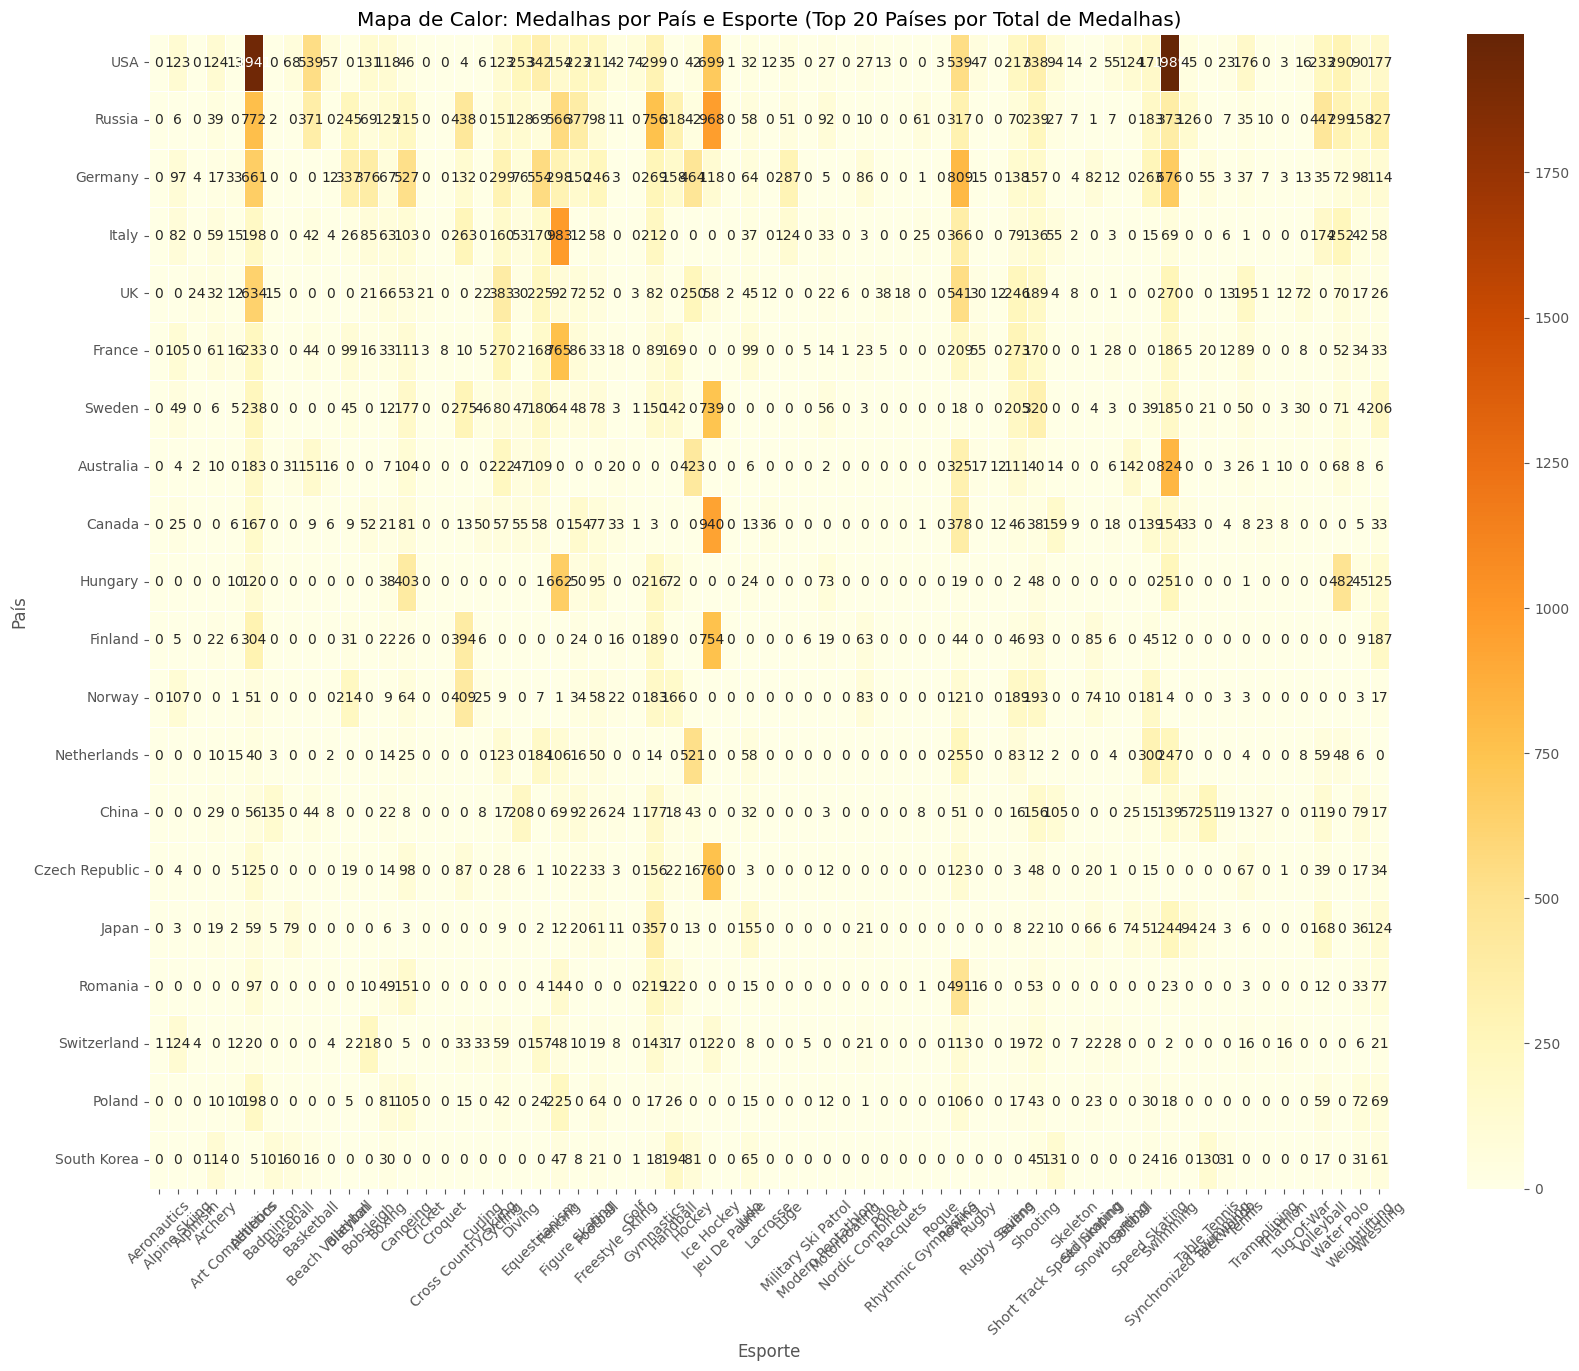

In [0]:
# Preparar os dados com ordenação por total de medalhas
heatmap_data = spark.sql("""
SELECT 
    l.country,
    e.sport,
    COUNT(fr.medal) AS total_medals
FROM fact_results fr
JOIN dim_locations l ON fr.location_id = l.location_id
JOIN dim_events e ON fr.event_id = e.event_id
GROUP BY l.country, e.sport
ORDER BY total_medals DESC
""").toPandas()

# Calcular o total de medalhas por país para ordenação
country_totals = heatmap_data.groupby('country')['total_medals'].sum().sort_values(ascending=False)

# Pegar os top 20 países por total de medalhas
top_countries = country_totals.head(20).index.tolist()

# Filtrar os dados apenas para os top 20 países
filtered_data = heatmap_data[heatmap_data['country'].isin(top_countries)]

# Pivotar os dados para o mapa de calor, mantendo a ordenação
heatmap_pivot = filtered_data.pivot(index='country', columns='sport', values='total_medals').fillna(0)

# Reordenar as linhas conforme a ordenação por total de medalhas
heatmap_pivot = heatmap_pivot.reindex(top_countries)

# Plotar
plt.figure(figsize=(20, 15))
sns.heatmap(heatmap_pivot, cmap="YlOrBr", annot=True, fmt=".0f", linewidths=.5)
plt.title('Mapa de Calor: Medalhas por País e Esporte (Top 20 Países por Total de Medalhas)')
plt.xlabel('Esporte')
plt.ylabel('País')
plt.xticks(rotation=45)
plt.yticks(rotation=0)  # Mantém os países na horizontal para melhor legibilidade
display(plt.show())

<Axes: xlabel='country'>

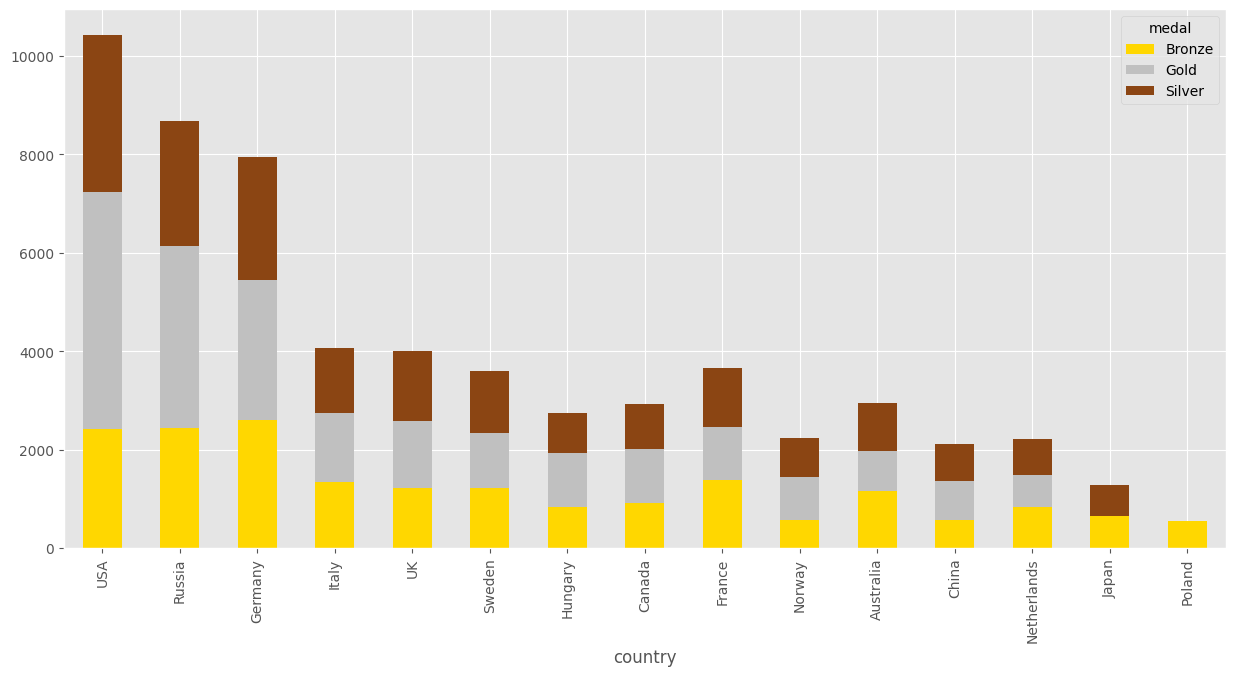

In [0]:
# Preparar os dados
stacked_bar_data = spark.sql("""
SELECT 
    l.country,
    fr.medal,
    COUNT(*) AS count
FROM fact_results fr
JOIN dim_locations l ON fr.location_id = l.location_id
WHERE fr.medal IS NOT NULL
GROUP BY l.country, fr.medal
ORDER BY count DESC
LIMIT 50
""").toPandas()

# Pivotar para formato empilhado
stacked_pivot = stacked_bar_data.pivot(index='country', columns='medal', values='count').fillna(0)

# Plotar
stacked_pivot.sort_values(by='Gold', ascending=False).head(15).plot(
    kind='bar', 
    stacked=True,
    figsize=(15, 7),
    color=['gold', 'silver', 'saddlebrown'])

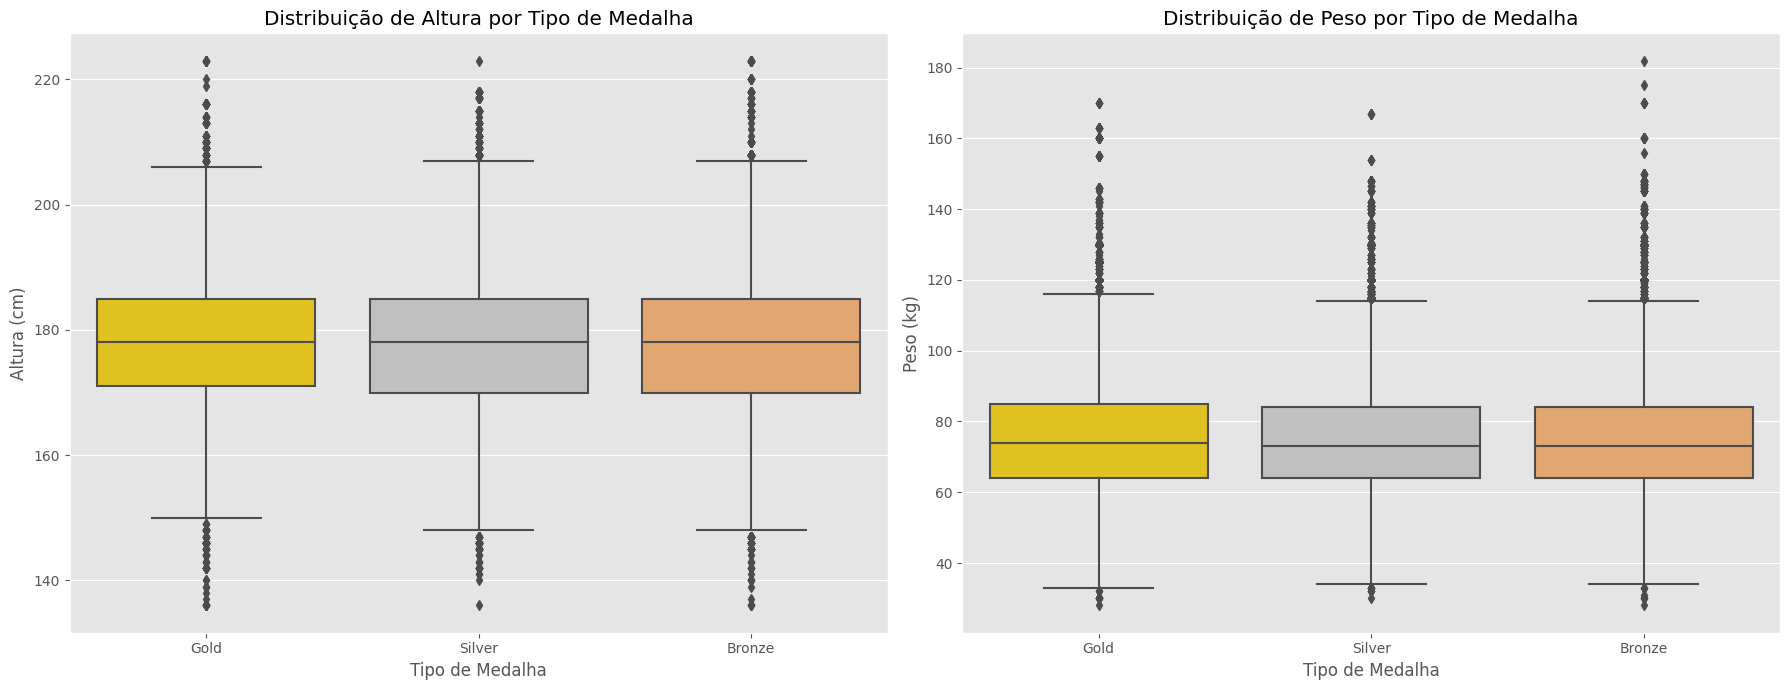

In [0]:
# Preparar os dados
physical_data = spark.sql("""
SELECT 
    a.height,
    a.weight,
    fr.medal
FROM fact_results fr
JOIN dim_athletes a ON fr.athlete_id = a.athlete_id
WHERE a.height IS NOT NULL AND a.weight IS NOT NULL AND fr.medal IS NOT NULL
""").toPandas()

# Criar figura com subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Boxplot para altura
sns.boxplot(x='medal', y='height', data=physical_data, 
            order=['Gold', 'Silver', 'Bronze'],
            palette=['gold', 'silver', 'sandybrown'], ax=ax1)
ax1.set_title('Distribuição de Altura por Tipo de Medalha')
ax1.set_xlabel('Tipo de Medalha')
ax1.set_ylabel('Altura (cm)')

# Boxplot para peso
sns.boxplot(x='medal', y='weight', data=physical_data, 
            order=['Gold', 'Silver', 'Bronze'],
            palette=['gold', 'silver', 'sandybrown'], ax=ax2)
ax2.set_title('Distribuição de Peso por Tipo de Medalha')
ax2.set_xlabel('Tipo de Medalha')
ax2.set_ylabel('Peso (kg)')

plt.tight_layout()
display(plt.show())

In [0]:
# Plot interativo com Plotly
scatter_data = physical_data[physical_data['medal'].notnull()]

fig = px.scatter(
    scatter_data,
    x='weight',
    y='height',
    color='medal',
    color_discrete_map={'Gold': 'gold', 'Silver': 'silver', 'Bronze': 'peru'},
    title='Relação entre Altura e Peso por Tipo de Medalha',
    labels={'weight': 'Peso (kg)', 'height': 'Altura (cm)'},
    hover_name='medal',
    size_max=15
)

fig.update_layout(
    legend_title_text='Tipo de Medalha',
    xaxis_range=[40, 150],
    yaxis_range=[140, 220]
)

display(fig)

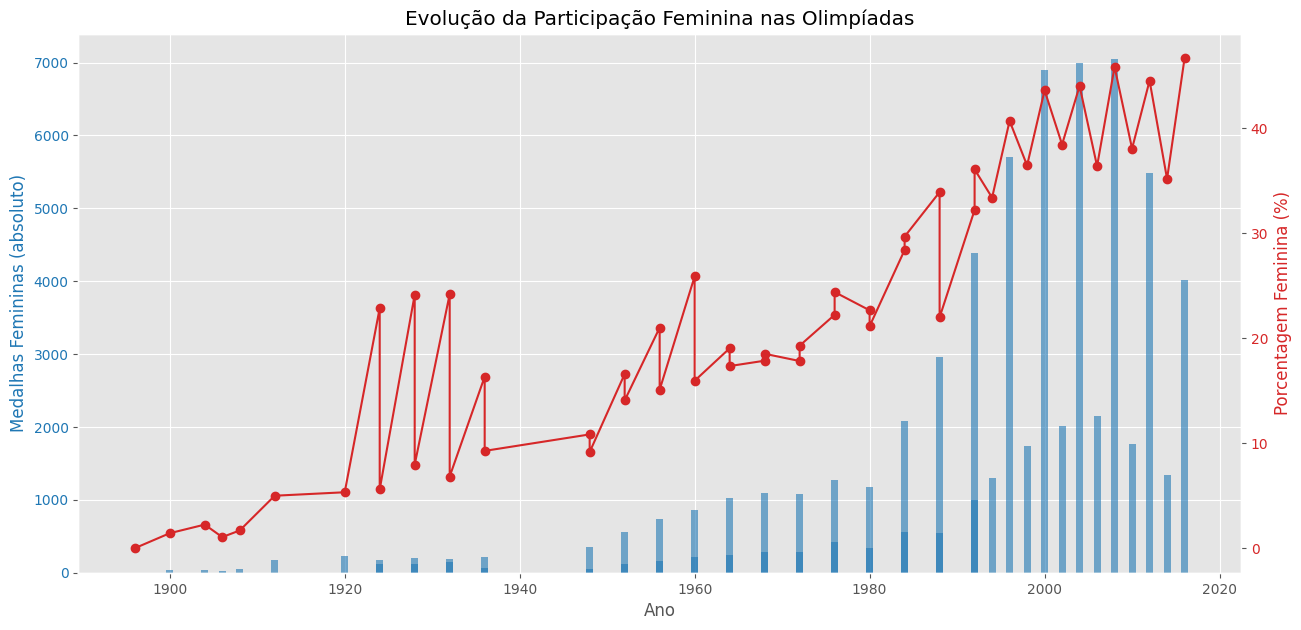

In [0]:
# Preparar os dados
female_evolution = spark.sql("""
SELECT 
    t.year,
    t.season,
    COUNT(CASE WHEN a.sex = 'F' AND fr.medal IS NOT NULL THEN 1 END) AS female_medals,
    COUNT(fr.medal) AS total_medals,
    ROUND(COUNT(CASE WHEN a.sex = 'F' AND fr.medal IS NOT NULL THEN 1 END) * 100.0 / 
        NULLIF(COUNT(fr.medal), 0), 2) AS female_percentage
FROM fact_results fr
JOIN dim_athletes a ON fr.athlete_id = a.athlete_id
JOIN dim_time t ON fr.time_id = t.time_id
WHERE fr.medal IS NOT NULL
GROUP BY t.year, t.season
ORDER BY t.year
""").toPandas()

# Criar figura com eixo secundário
fig, ax1 = plt.subplots(figsize=(15, 7))

# Gráfico de barras para medalhas absolutas
color = 'tab:blue'
ax1.set_xlabel('Ano')
ax1.set_ylabel('Medalhas Femininas (absoluto)', color=color)
ax1.bar(female_evolution['year'], female_evolution['female_medals'], color=color, alpha=0.6)
ax1.tick_params(axis='y', labelcolor=color)

# Gráfico de linha para porcentagem
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Porcentagem Feminina (%)', color=color)
ax2.plot(female_evolution['year'], female_evolution['female_percentage'], color=color, marker='o')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Evolução da Participação Feminina nas Olimpíadas')
plt.grid(False)
display(plt.show())

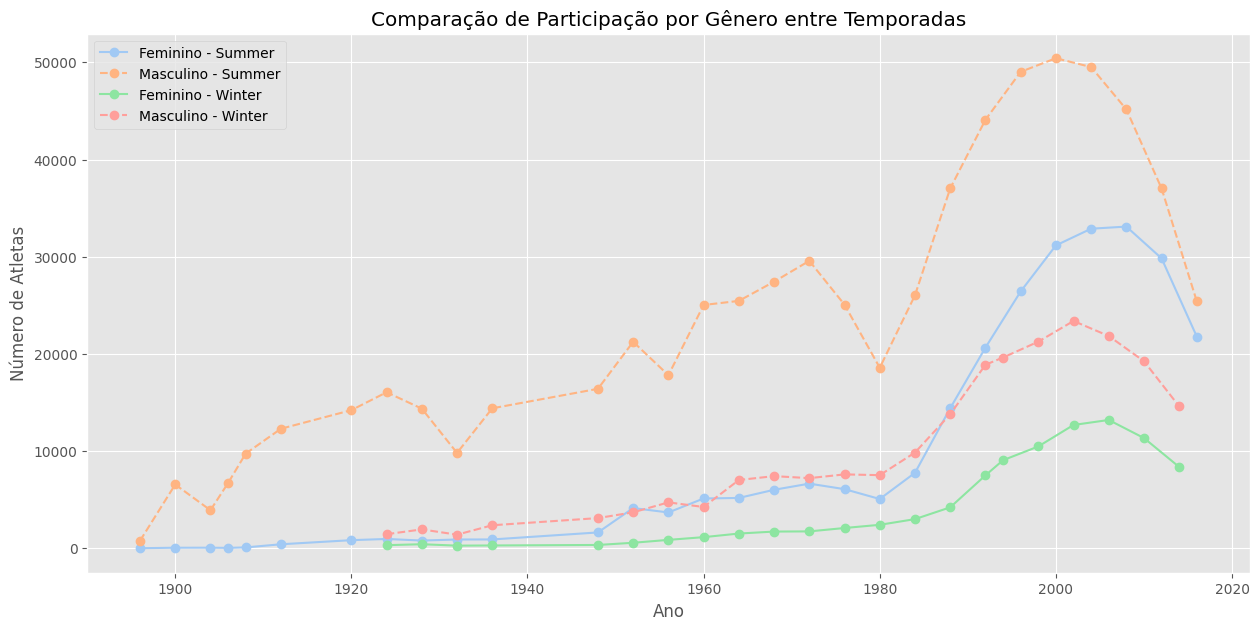

In [0]:
# Preparar os dados
season_comparison = spark.sql("""
SELECT 
    t.season,
    t.year,
    COUNT(CASE WHEN a.sex = 'F' THEN 1 END) AS female_athletes,
    COUNT(CASE WHEN a.sex = 'M' THEN 1 END) AS male_athletes
FROM fact_results fr
JOIN dim_athletes a ON fr.athlete_id = a.athlete_id
JOIN dim_time t ON fr.time_id = t.time_id
GROUP BY t.season, t.year
ORDER BY t.year
""").toPandas()

# Plotar
plt.figure(figsize=(15, 7))
for season in ['Summer', 'Winter']:
    subset = season_comparison[season_comparison['season'] == season]
    plt.plot(subset['year'], subset['female_athletes'], 
             label=f'Feminino - {season}', marker='o')
    plt.plot(subset['year'], subset['male_athletes'], 
             linestyle='--', label=f'Masculino - {season}', marker='o')

plt.title('Comparação de Participação por Gênero entre Temporadas')
plt.xlabel('Ano')
plt.ylabel('Número de Atletas')
plt.legend()
plt.grid(True)
display(plt.show())

In [0]:
# Preparar dados geográficos
world_map_data = spark.sql("""
SELECT 
    l.country,
    l.region,
    COUNT(CASE WHEN fr.medal = 'Gold' THEN 1 END) AS gold,
    COUNT(CASE WHEN fr.medal = 'Silver' THEN 1 END) AS silver,
    COUNT(CASE WHEN fr.medal = 'Bronze' THEN 1 END) AS bronze,
    COUNT(fr.medal) AS total
FROM fact_results fr
JOIN dim_locations l ON fr.location_id = l.location_id
WHERE fr.medal IS NOT NULL
GROUP BY l.country, l.region
""").toPandas()

# Criar mapa interativo
fig = px.choropleth(
    world_map_data,
    locations="country",
    locationmode="country names",
    color="total",
    hover_name="country",
    hover_data=["gold", "silver", "bronze"],
    color_continuous_scale=px.colors.sequential.Plasma,
    title="Distribuição Mundial de Medalhas Olímpicas"
)

fig.update_layout(margin={"r":0,"t":40,"l":0,"b":0})
display(fig)

In [0]:
# Consulta para obter dados de distribuição de medalhas por esporte
equilibrio_esportes = spark.sql("""
SELECT 
    e.sport,
    COUNT(DISTINCT l.country) AS paises_medalhistas,
    COUNT(fr.medal) AS total_medalhas,
    COUNT(fr.medal) / COUNT(DISTINCT l.country) AS medalhas_por_pais,
    STDDEV_POP(COUNT(fr.medal)) OVER (PARTITION BY e.sport) AS desvio_padrao_medalhas
FROM fact_results fr
JOIN dim_events e ON fr.event_id = e.event_id
JOIN dim_locations l ON fr.location_id = l.location_id
WHERE fr.medal IS NOT NULL
GROUP BY e.sport
ORDER BY paises_medalhistas DESC
""").toPandas()

# Calcular índice de equilíbrio (quanto maior, mais equilibrado)
equilibrio_esportes['indice_equilibrio'] = (equilibrio_esportes['paises_medalhistas'] / 
                                           equilibrio_esportes['total_medalhas']) * 100

# Selecionar os 20 esportes mais equilibrados
top_equilibrio = equilibrio_esportes.nlargest(20, 'indice_equilibrio')

# Criar visualização interativa
fig = px.scatter(
    top_equilibrio,
    x='paises_medalhistas',
    y='indice_equilibrio',
    size='total_medalhas',
    color='sport',
    hover_name='sport',
    hover_data=['medalhas_por_pais'],
    labels={
        'paises_medalhistas': 'Número de Países Medalhistas',
        'indice_equilibrio': 'Índice de Equilíbrio (%)',
        'total_medalhas': 'Total de Medalhas',
        'sport': 'Esporte',
        'medalhas_por_pais': 'Medalhas por País'
    },
    title='Esportes com Maior Equilíbrio de Medalhas entre Países (Top 20)'
)

fig.update_layout(
    xaxis=dict(title='Quantidade de Países Diferentes que Conquistaram Medalhas'),
    yaxis=dict(title='Índice de Equilíbrio (Quanto maior, mais equilibrado)'),
    hovermode='closest'
)

display(fig)

In [0]:
# Selecionar os 20 esportes MENOS equilibrados
bottom_equilibrio = equilibrio_esportes.nsmallest(20, 'indice_equilibrio')

# Criar visualização interativa
fig = px.bar(
    bottom_equilibrio.sort_values('indice_equilibrio', ascending=True),
    x='sport',
    y='indice_equilibrio',
    color='paises_medalhistas',
    hover_data=['total_medalhas', 'medalhas_por_pais'],
    labels={
        'sport': 'Esporte',
        'indice_equilibrio': 'Índice de Desequilíbrio (%)',
        'paises_medalhistas': 'Países Medalhistas',
        'total_medalhas': 'Total de Medalhas',
        'medalhas_por_pais': 'Medalhas por País'
    },
    title='Esportes com Menor Equilíbrio de Medalhas entre Países (Top 20)',
    color_continuous_scale='reds'
)

fig.update_layout(
    xaxis_title='Esporte',
    yaxis_title='Índice de Desequilíbrio (Quanto menor, mais concentrado)',
    yaxis=dict(autorange="reversed"),  # Inverte o eixo Y para mostrar o menos equilibrado no topo
    coloraxis_colorbar=dict(title='Nº de Países<br>Medalhistas')
)

display(fig)